## Orientation Tracking 

#### Installing required libraries

In [1390]:
!pip install -r requirements.txt

#### Importing libraries

In [1391]:
import os
import autograd
import autograd.numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from enum import Enum
from typing import Callable
import transforms3d, pickle, re


#### Loading the Datasets

In [1392]:
class DataType(Enum):
    cam = "cam"
    imu = "imu"
    vicon = "vicon"

def get_data_file(datasetType: str, dataType: DataType) -> defaultdict: 
    data_files = defaultdict()
    data_path = os.path.join(os.getcwd(), "data/" + datasetType +"/" + dataType.value)
    if os.path.isdir(data_path):
        files = os.listdir(data_path)
        for file in files:
            if file.endswith(".p"):
                match = re.search(r'\d+', file)
                if match:
                    key = int(match.group())
                    with open(os.path.join(data_path, file), 'rb') as file:
                        data_files[key] = pickle.load(file, encoding='latin1')  # need for python 3
        return data_files
    else:
        assert "Invalid datapath"


In [1393]:

## IMU, CAM, VICON Data loading
imu_data_files = get_data_file(datasetType="trainset", dataType=DataType.imu)
cam_data_files = get_data_file(datasetType="trainset", dataType=DataType.cam)
vicon_data_files = get_data_file(datasetType="trainset", dataType=DataType.vicon)

imu_data_files_train = get_data_file(datasetType="testset", dataType=DataType.imu)
cam_data_files_train = get_data_file(datasetType="testset", dataType=DataType.cam)

## Give the dataset number here before running

In [1394]:
dataset_number = 8

#### Visualize the IMU data

In [1395]:
def plotting_data(type: str, data: np.ndarray, num_samples: int, title_str: str, coord_str: list) -> None:
    x = np.linspace(0, num_samples, num_samples)
    _, axes = plt.subplots(1, 3, figsize=(16, 4))
    for i in range(3):
        plot_data = data[i]
        axes[i].plot(x, data[i][:num_samples])
        if(coord_str == None):
            continue
        axes[i].set_title(title_str+ type + " in " + coord_str[i])
    plt.subplots_adjust(wspace=0.3)
    plt.show()

def plotting_data_2( data: np.ndarray, data2: np.ndarray, coord_str: list) -> None:
    fig = plt.figure(figsize=(16, 4))
    
    for i in range(3):  
        plt.subplot(1, 3, i+1)
        plt.plot(np.linspace(0, data.shape[0], data.shape[0]), data[:, i], label="Vicon")
        plt.plot(np.linspace(0, data2.shape[0], data2.shape[0]), data2[:, i], label="Optim")
        plt.title(coord_str[i])
        plt.legend()
    plt.show()

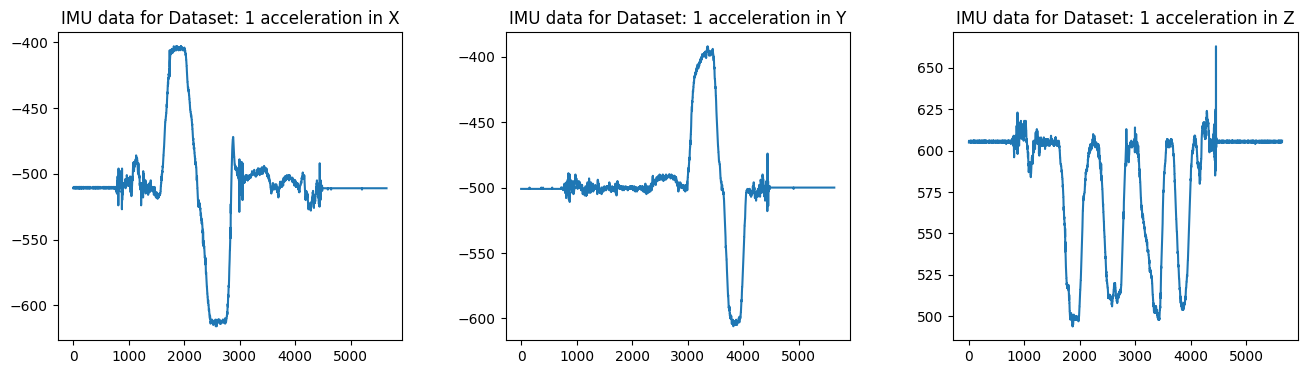

In [1396]:
if dataset_number in [1, 2, 3, 4, 5, 6, 7, 8, 9]:
    plotting_data("Dataset: " + str(dataset_number)  + " acceleration", imu_data_files[dataset_number][1:4][:], imu_data_files[dataset_number][1:4][:].shape[1], "IMU data for ", coord_str = ["X", "Y", "Z"])
else:
    plotting_data("Dataset: " + str(dataset_number)  + " acceleration", imu_data_files_train[dataset_number][1:4][:], imu_data_files_train[dataset_number][1:4][:].shape[1], "IMU data for ", coord_str = ["X", "Y", "Z"])


#### Account the bias in IMU data

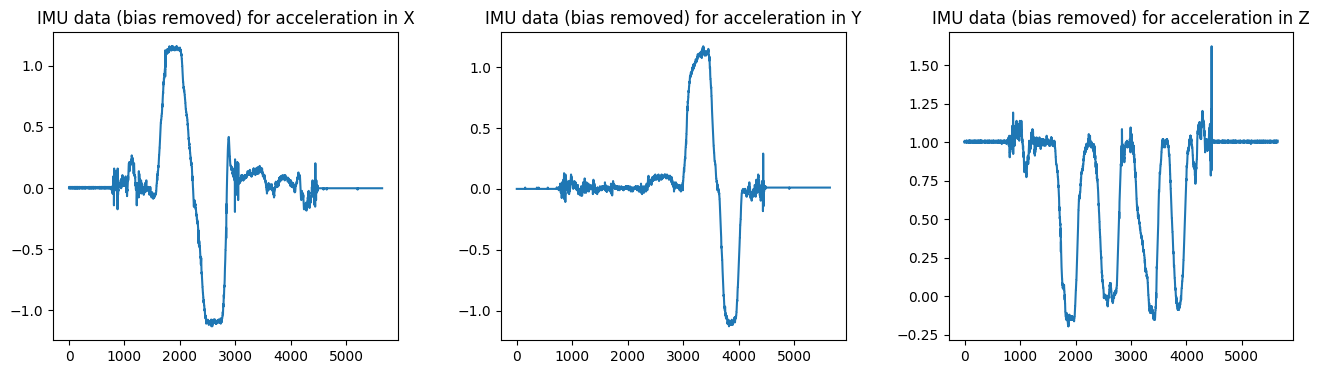

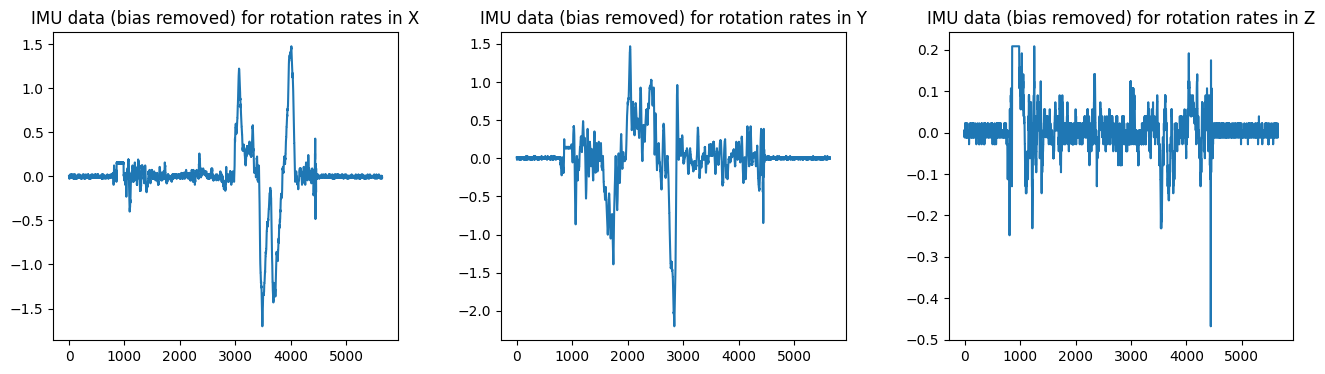

In [1397]:
""""
    The equation to convert from the raw A/D values to physical units is

    value = (raw − bias) × scale factor
    scale factor = Vref/1023/sensitivity

    Vref=3.3V=3300mV=reference voltage for A/D converter
    The A/D converter is 10 bit, so maximum value is 1023
    sensitivity for accelerometers is measured in mV/g and for rate gyros in mV/degree/sec

    For example, the value in radians for a given raw rate gyro measurement is: 
    value = 3300/1023 × π/180/sensitivity

    The acceleration measured by the accelerometer in the first few seconds should be [0, 0, 1]⊤ in gravity units.
"""""

def bias_calculate(data:np.ndarray, numsamples:int) -> np.ndarray:
    return np.mean(data[:, :numsamples], axis=1)

Vref = 3300

## Accelerometer
imu_accel_data = imu_data_files[dataset_number][1:4, :]
sensitivity_accelerometer = 300 #mV/g
scalefactor_accelerometer = 3300/(1023 * sensitivity_accelerometer) #g
bias_accelerometer = bias_calculate(imu_accel_data, 100) * scalefactor_accelerometer - np.array([0, 0, 1])
value_accelerometer = imu_accel_data  * scalefactor_accelerometer - bias_accelerometer[:, np.newaxis]


## Gyroscope
imu_gyro_data = imu_data_files[dataset_number][4:7, :]
sensitivity_gyroscope =  3.33 #mV/ °/s
scalefactor_gyroscope = (3300/(1023 * sensitivity_gyroscope)) * (np.pi/180) #rad
bias_gyroscope = bias_calculate(imu_gyro_data, 100)
value_gyroscope = (imu_gyro_data - bias_gyroscope[:, np.newaxis])*scalefactor_gyroscope


plotting_data("acceleration", value_accelerometer, value_accelerometer.shape[1], "IMU data (bias removed) for ", coord_str = ["X", "Y", "Z"])
plotting_data("rotation rates", value_gyroscope, value_gyroscope.shape[1], "IMU data (bias removed) for ", coord_str = ["X", "Y", "Z"])

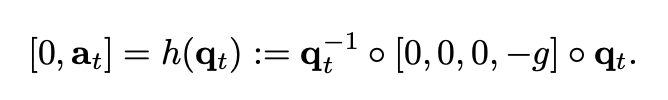

In [1398]:
"""""
    The measured acceleration at in the IMU frame should agree with 
    gravity acceleration after it is transformed to the IMU frame using 
    the orientation qt, leading to the following observation model:
    
    [0,at] = h(qt) := qt−1 ◦ [0,0,0,−g] ◦ qt .
"""""

def h(q: np.ndarray, g: float) -> np.ndarray:
    
    q_inv = np.concatenate([[q[0]], -q[1:]])/np.square(np.linalg.norm(q))
    q_gravity = np.concatenate([[0.0], [0.0, 0.0, g]])
    
    q_inv_s, q_inv_v = q_inv[0], q_inv[1:]
    q_gravity_s, q_gravity_v = q_gravity[0], q_gravity[1:]

    q_new = np.concatenate([[q_inv_s * q_gravity_s - np.dot(q_inv_v, q_gravity_v)], q_inv_s * q_gravity_v + q_gravity_s * q_inv_v + np.cross(q_inv_v, q_gravity_v)])

    q_new_s, q_new_v = q_new[0], q_new[1:]
    q_s, q_v = q[0], q[1:]

    return np.concatenate([[q_new_s * q_s - np.dot(q_new_v, q_v)], q_new_s * q_v + q_s * q_new_v + np.cross(q_new_v, q_v)])

In [1399]:
def get_size(imuData, viconData) -> tuple:
    if(imuData is None):
        return viconData['rots'].shape, viconData['ts'].shape
    if(viconData is None):
        return imuData.shape[0], imuData.shape[1]
    return imuData.shape[0], imuData.shape[1], viconData['rots'].shape, viconData['ts'].shape

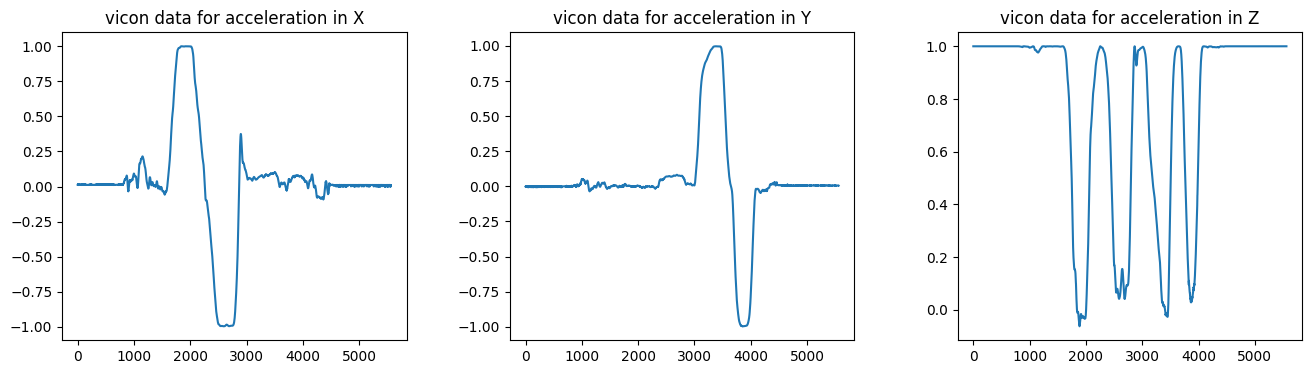

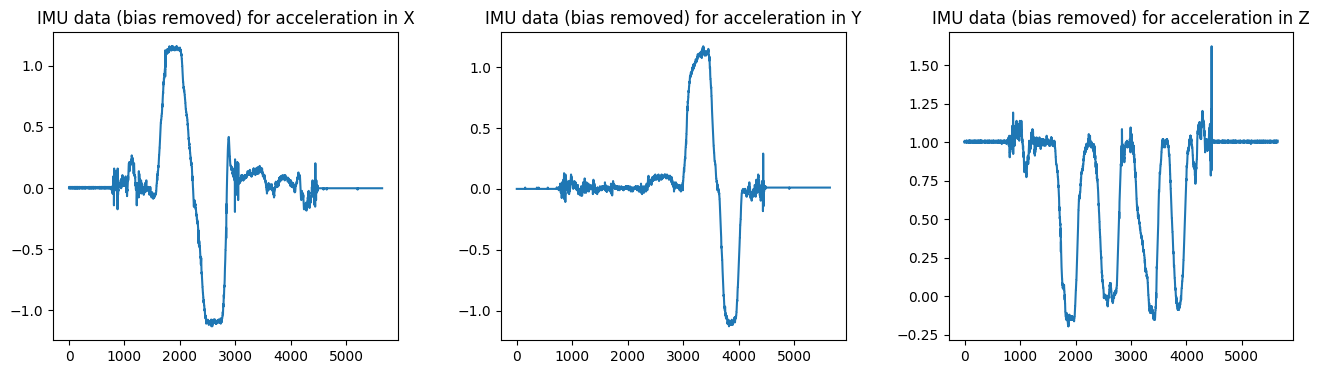

In [1400]:
vicon_rots_shape, vicon_ts_shape = get_size(None, vicon_data_files[dataset_number])
vicon_euler = np.zeros((3, vicon_ts_shape[1]), dtype=np.float32)
vicon_quaternions = np.zeros((4, vicon_ts_shape[1]), dtype=np.float32)
vicon_acclerators = np.zeros((4, vicon_ts_shape[1]), dtype=np.float32)

for i in range(vicon_euler.shape[1]):
    rot = vicon_data_files[1]['rots'][:, :, i]
    vicon_euler[:, i] = np.array(transforms3d.euler.mat2euler(rot)) * 180/np.pi
    vicon_quaternions[:, i] = np.array(transforms3d.quaternions.mat2quat(rot))
    vicon_acclerators[:, i] = h(vicon_quaternions[:, i], 1)


plotting_data("acceleration", vicon_acclerators[1:], vicon_acclerators.shape[1], "vicon data for ", coord_str = ["X", "Y", "Z"])
plotting_data("acceleration", value_accelerometer, value_accelerometer.shape[1], "IMU data (bias removed) for ", coord_str = ["X", "Y", "Z"])


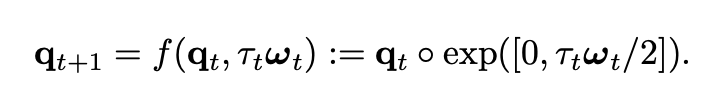

In [1401]:
"""""
    q ◦ p = [q]Lp = [p]Rq

    [q]L := [q G(q)⊤]
    [q]R := [q E(q)⊤]

    G(q) = [−qv , qsI − qˆv ]
    E(q) = [−qv , qsI + qˆv ]

    q ◦ p := [qsps − qvT pv , qspv + psqv + qv × pv]


    Using the IMU angular velocity measurements ωt and the differences
    between consecutive time stamps τt, we can predict the quaternion 
    at the next step qt+1 using the quaternion kinematics motion model:
    
    qt+1 = f(qt,τtωt) := qt ◦ exp([0,τtωt/2])

    where exp(q) = e^qs[cos ∥qv ∥, qv/∥qv ∥ sin ∥qv ∥]is the quaternion exponential function.
"""""

def f(q:np.ndarray, τ: float, ω: np.ndarray) -> np.ndarray:
    ω = np.concatenate([[0.0], ω * τ / 2.0])
    ω_qs, ω_qv = ω[0], ω[1:]
    ω_qs_norm, ω_qv_norm = np.linalg.norm(ω_qs), np.linalg.norm(ω_qv)
    if(ω_qv_norm==0):
        exp_q = [1.0, 0.0, 0.0, 0.0]
    else:
        exp_q = np.exp(ω_qs) * np.concatenate([[np.cos(ω_qv_norm)], (ω_qv / ω_qv_norm ) * np.sin(ω_qv_norm)]) 
    # if(np.linalg.norm(exp_q) != 1) :
    #     print(exp_q, np.linalg.norm(exp_q))
    qt_s, qt_v = q[0], q[1:]
    exp_q_s, exp_q_v = exp_q[0], exp_q[1:]
    qt_1 = np.concatenate([[qt_s * exp_q_s - np.dot(qt_v, exp_q_v)], qt_s * exp_q_v + exp_q_s * qt_v + np.cross(qt_v, exp_q_v)])
    # if(np.linalg.norm(qt_1) != 1) :
    #     print(qt_1, np.linalg.norm(qt_1))
    return qt_1
    

In [1402]:
"""""
    converting the quartenions to euler angles
    converting the rotational_matrices to euler angles
"""""


def convertQ_euler(data: np.ndarray) -> np.ndarray:
    data_h, data_w = get_size(data, None)
    euler = np.zeros((3, data_w), dtype=np.float32)
    # print(data.shape)

    for i in range(data_w):
        euler[:, i] = np.asarray(transforms3d.euler.quat2euler(data[:, i], axes='sxyz')) * 180/np.pi

    return euler

def convertROT_euler(data: np.ndarray) -> np.ndarray:
    data_rots_size, data_ts_size = get_size(None, data)
    euler = np.zeros((3, data_ts_size[1]), dtype=np.float32)

    for i in range(data_ts_size[1]):
        euler[:, i] = np.array(transforms3d.euler.mat2uler(data['rots'][:,:,i])) * 180/np.pi

    return euler

In [1403]:
"""""
    Start-ing with q0 = [1,0,0,0], implement a simple integration of the 
    angular velocity ωt computing qt+1 = f(qt,τtωt). using motion model.
"""""

def predictQ_from_IMU(imudata: np.ndarray) -> np.ndarray:
    imudata_h, imudata_w = get_size(imudata, None)
    q_pred = np.zeros((4, imudata_w), dtype=np.float32)
    
    for i in range(imudata_w):
        if(i == 0):
            q_pred[:, 0] = np.array([1.0, 0.0, 0.0, 0.0])
        else:
            τ = imudata[0, i] - imudata[0, i-1]
            ω = imudata[1:4, i]
            q_pred[:, i] = f(q_pred[:, i-1], τ, ω)
    return q_pred

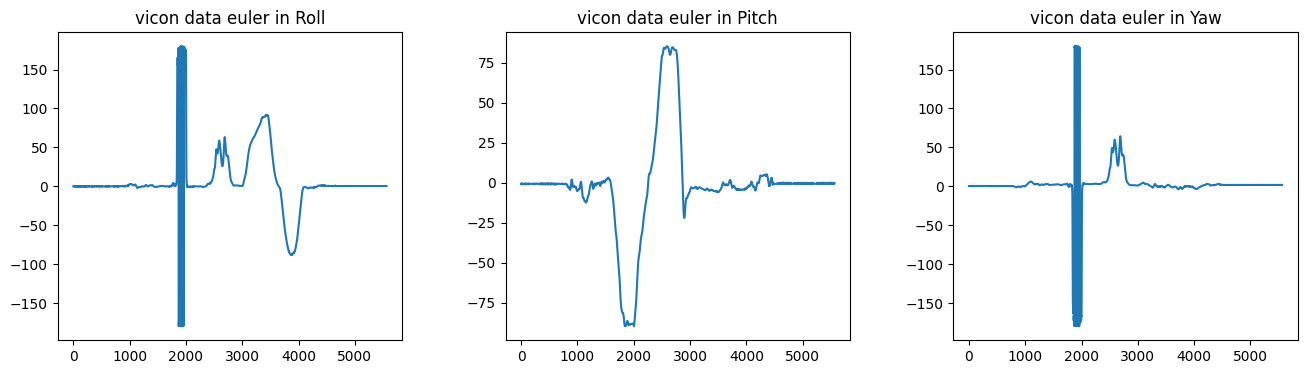

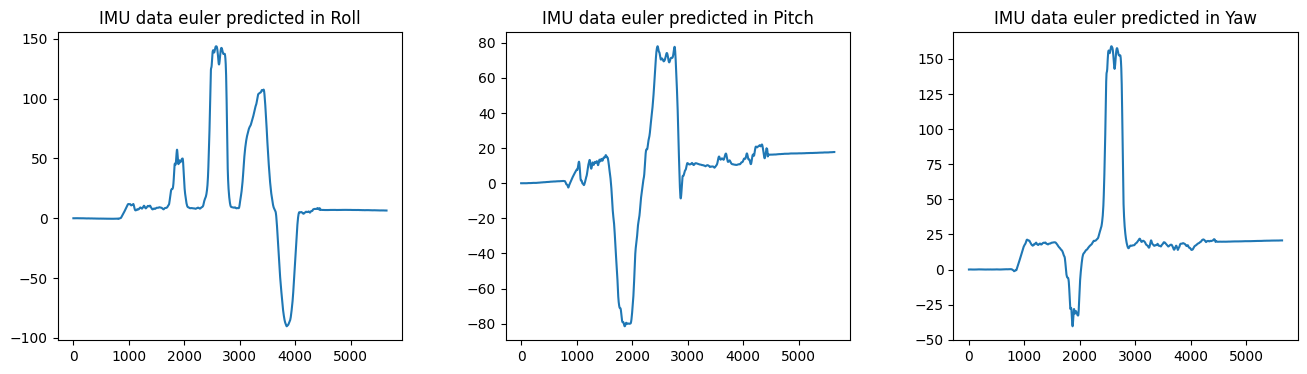

In [1404]:
"""""
    Plot the roll, pitch, yaw obtained from qt and compare them 
    to the values provided by the VICON ground truth
"""""

imu_data_τ = imu_data_files[dataset_number][0, :]

imu_data = np.concatenate([[imu_data_τ], value_gyroscope])
Q_pred = predictQ_from_IMU(imu_data)
Q_pred_euler = convertQ_euler(Q_pred)

plotting_data("euler", vicon_euler, vicon_euler.shape[1], "vicon data ", coord_str = ["Roll", "Pitch", "Yaw"])
plotting_data("euler predicted", Q_pred_euler, Q_pred_euler.shape[1], "IMU data ", coord_str = ["Roll", "Pitch", "Yaw"])

### Quternion Operations

In [1405]:
def exponent_quaternion(q: np.ndarray) -> np.ndarray:
    q = q.T
    q_s, q_v = q[0, :], q[1:, :]
    q_v_norm = np.linalg.norm(q_v, axis=0)[np.newaxis, :]
    q_v_norm[q_v_norm == 0] = 1e-9
    exp_q_s = np.exp(q_s) * np.cos(q_v_norm)
    exp_q_v = np.exp(q_s) * ((q_v/q_v_norm) * np.sin(q_v_norm))
    return np.concatenate((exp_q_s, exp_q_v)).T


def logarthmic_quternion(q:np.ndarray) -> np.ndarray:
    assert(q.shape[1] == 4)
    q_s, q_v = q[:, 0], q[:, 1:]
    q_v_norm, q_norm = np.linalg.norm(q_v, axis=1) + 1e-9, np.linalg.norm(q, axis=1) + 1e-9
    log_q_s = np.log(q_norm)
    log_q_v = np.expand_dims(np.arccos(q_s / q_norm), axis=1) * q_v / np.expand_dims(q_v_norm, axis=1)
    log_q = np.array([log_q_s, log_q_v[:,0], log_q_v[:,1], log_q_v[:,2]])
    return log_q

def inverse_quternion(q: np.ndarray) -> np.ndarray:
    q = q.T
    q_s, q_v = q[0, :], q[1:, :]
    q_norm_sq = np.square(np.linalg.norm(q, axis=0))[np.newaxis, :]
    return (np.concatenate((q_s[np.newaxis, :], -q_v))/q_norm_sq).T

def product_quternion(q: np.ndarray, p: np.ndarray) -> np.ndarray:
    q, p = q.T, p.T
    q_s, q_v = q[0, :][np.newaxis, :], q[1:, :]
    p_s, p_v = p[0, :][np.newaxis, :], p[1:, :]
    product_s = q_s * p_s - np.sum((q_v * p_v), axis=0)
    product_v = q_s * p_v + p_s * q_v + np.cross(q_v.T, p_v.T).T
    return np.concatenate((product_s, product_v)).T


In [1406]:
imu_data_τ =  imu_data_files[dataset_number][0, :].T
vicon_data_rots, vicon_data_ts = np.transpose(vicon_data_files[dataset_number]['rots'], (2, 0, 1)), vicon_data_files[dataset_number]['ts'].T

In [1407]:
def f_(q: np.ndarray, τ: np.ndarray, ω: np.ndarray) -> np.ndarray:
    τω_ = np.zeros_like(q)
    τω_[:, 1:] = τ * ω / 2
    exp_q = exponent_quaternion(τω_)
    return product_quternion(q, exp_q)


def h_(q: np.ndarray, g: float) -> np.ndarray:
    tmp = np.zeros_like(q)
    tmp[:, 3] = g
    return product_quternion(product_quternion(inverse_quternion(q), tmp), q)

### Cost Function

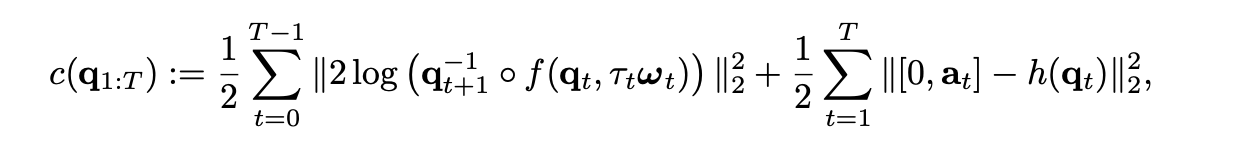

In [1408]:
def cost_function(q: np.ndarray) -> float:
    cost = 0
    noise = np.random.rand(q.shape[0], q.shape[1]) * 1e-9    
    q_inv = inverse_quternion(q)

    q_ = np.vstack([np.array([1.0, 0.0, 0.0, 0.0]), q[0:-1]])
    τ = (imu_data_τ[1:] - imu_data_τ[0:-1])[:, np.newaxis]
    ω = value_gyroscope.T[:-1, :]
    f = f_(q_, τ, ω) 
    
    cost = cost + 0.5 * np.sum(np.square(np.linalg.norm(2 * logarthmic_quternion(product_quternion(q_inv, f) + noise), axis=1)))
    cost = cost + 0.5 * np.sum(np.square(np.linalg.norm(value_accelerometer.T[1:, :] - h_(q, 1.0)[:, 1:], axis=1)))

    return cost

### Projected Gradient Descent

In [1409]:
costs = []              
q = Q_pred[:, :-1].T
grad_cost = autograd.jacobian(cost_function)
costs.append(cost_function(q))

num_iterations = 600
lr = 1e-2
for i in range(num_iterations):
    q = q - lr * grad_cost(q)
    q = q / np.reshape(np.linalg.norm(q, axis=1), (q.shape[0], 1)) ## Unit quaternion projection
    costs.append(cost_function(q))
    if (i%50 ==0) :
        print(f"For iteration i: {i} costfunction value: {costs[-1]} ")

q_optim = q

For iteration i: 0 costfunction value: 201.16481820945845 
For iteration i: 50 costfunction value: 15.902933386404108 
For iteration i: 100 costfunction value: 13.06158334704335 
For iteration i: 150 costfunction value: 13.015014211145525 
For iteration i: 200 costfunction value: 13.014104711981457 
For iteration i: 250 costfunction value: 13.014054351922772 
For iteration i: 300 costfunction value: 13.014033652882281 
For iteration i: 350 costfunction value: 13.014018840893552 
For iteration i: 400 costfunction value: 13.014009239085318 
For iteration i: 450 costfunction value: 13.014001442735676 
For iteration i: 500 costfunction value: 13.013994549646814 
For iteration i: 550 costfunction value: 13.013988892994862 


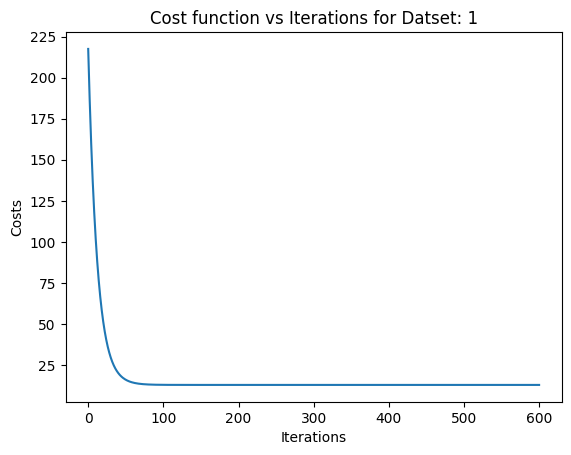

In [1410]:
## Plotting the cost function
plt.plot(costs)
plt.title("Cost function vs Iterations for Datset: " + str(dataset_number))
plt.xlabel("Iterations")
plt.ylabel("Costs")
plt.show()

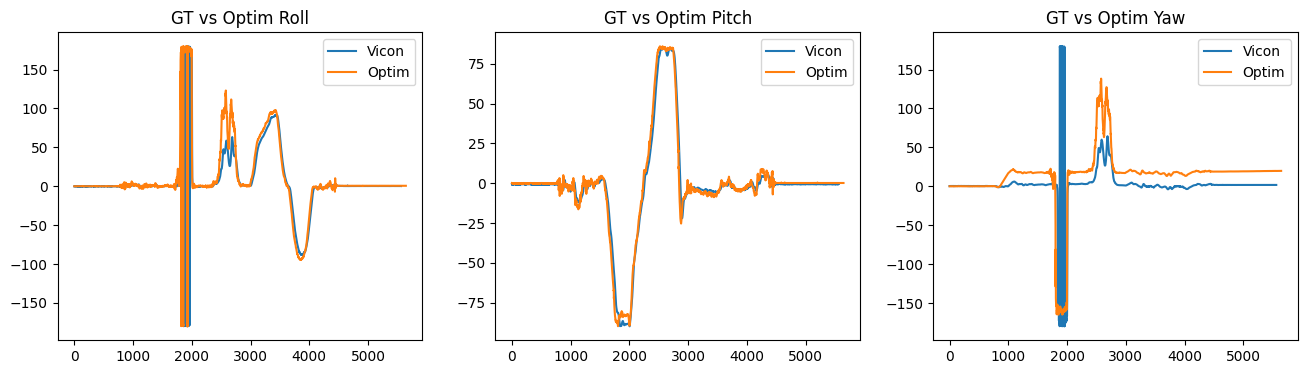

In [1411]:
## Convert optmised quternions to euler

q_optim_euler = convertQ_euler(q_optim.T).T
plotting_data_2(vicon_euler.T, q_optim_euler,["GT vs Optim Roll", 
              "GT vs Optim Pitch", 
              "GT vs Optim Yaw"])

## Panaroma Stiching

In [1412]:
cam_data_image, cam_data_ts = np.transpose(cam_data_files[dataset_number]['cam'], (3, 0, 1, 2)), cam_data_files[dataset_number]['ts'].T
num_images, image_h, image_w, num_channels = cam_data_image.shape


In [1413]:
"""""
    Converting spherical to cartesian &
    cartesian to spehrical coordinates
"""""

def convertCartesian_sphe(coord: np.ndarray, radius: float = 1.0) -> tuple:
    lambdaa = np.arcsin(-coord[:,:,2] / radius)
    phi = np.arctan2(coord[:,:,1], coord[:,:,0])
    return phi, lambdaa

def convertSpherical_cart(lambdaa: np.ndarray, phi: np.ndarray, radius: float =1.0) -> np.ndarray:
    phi_h, phi_w = phi.shape
    coord = np.zeros((phi_h, phi_w, 3))
    coord[:,:,0] = radius * np.cos(phi) * np.cos(lambdaa)
    coord[:,:,1] = radius * np.cos(phi) * np.sin(lambdaa)
    coord[:,:,2] = -1 * radius * np.sin(phi)
    return coord


#### Panaroma constants

In [1414]:

## Horizontal and Vertical Feild of View in degrees
HFOV = 60
VFOV = 45

## Panned Image size 
final_h = 900
final_w = 1080
final_size = (final_h+5 , final_w+5 , num_channels)

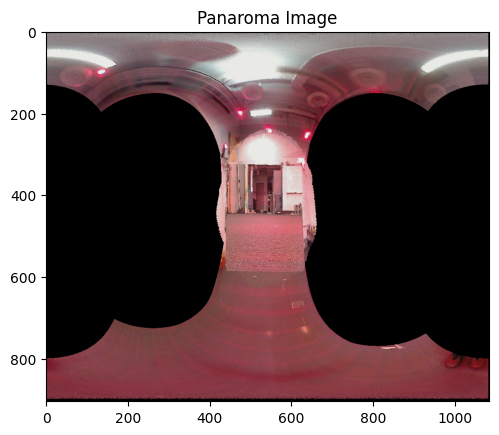

In [1415]:

final_image = np.zeros(final_size, dtype=np.uint32)
v_indices, u_indices = np.meshgrid(np.linspace(0, image_w - 1, image_w) , np.linspace(0, image_h - 1, image_h) )
lambdaa =  -((v_indices - image_w//2) * HFOV / image_w) * np.pi / 180.0
phi = ((u_indices - image_h//2) * VFOV / image_h) * np.pi / 180.0

coords = convertSpherical_cart(lambdaa, phi, 1.0)  ## Body frame

for t in range(num_images):
    rots_id = (len(vicon_data_ts) - 1) - np.argmax(np.flip(cam_data_ts[t] - vicon_data_ts > 0)) # Closest timestep
    coords_W = np.matmul(coords, vicon_data_rots[rots_id].T) ## world frame 
    lambdaa_w, phi_w = convertCartesian_sphe(coords_W)  ## World frame spherical 
    u_ = np.round(((phi_w + 0.5 * np.pi) / np.pi) * final_h).astype(np.int32) 
    v_ = np.round(((np.pi - lambdaa_w) / (2*np.pi)) * final_w).astype(np.int32)
    final_image[u_, v_] = np.copy(cam_data_image[t])

plt.title("Panaroma Image")
plt.imshow(final_image)